## Matrix Factorization
- importing libraries and data
- statistical and descision based accuracy measurment
    - k-fold cross validation
    - hold-out validation

### Importing libraries

In [1]:
from scipy.stats import norm
import numpy as np 
import matplotlib.pyplot as plt
import requests
from io import StringIO
import seaborn as sns
import pandas as pd
from sklearn.model_selection import KFold
from collections import defaultdict
from datetime import datetime
import math
import random
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import collections
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
import logging
import json
import pickle
import os.path

#### importing data

In [2]:
url = 'https://drive.google.com/file/d/1KbNla9qUZEvscEFbRe767Lq0N-xB2Uoo/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
result = pd.read_csv(path)
result.head()

,user_id,layout_id,ratings
0,u 2,L1,1.0
1,u 3,L1,1.0
2,u 3,L5,1.0
3,u 4,L1,1.0
4,u 4,GLHS2,1.0


#### k-fold cross validation

In [3]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(result) # returns the number of splitting iterations in the cross-validator
print(kf) 
KFold(n_splits=4, random_state=None, shuffle=False)

KFold(n_splits=5, random_state=None, shuffle=False)


KFold(n_splits=4, random_state=None, shuffle=False)

In [4]:
# Matrix Factorization (MF) training
result_rmse_factor ={}
class MF:
    
    Regularization = 0.002
    BiasLearnRate = 0.0002
    BiasReg = 0.001
    LearnRate = 0
    all_layouts_mean = 0
    number_of_ratings = 0
    save_path = 'Models/matrixfactorization'
    item_bias = None
    user_bias = None
    beta = 0.02
    L_factor = []
    L_error = []
    L_iterations = []
    L_iterations_error = []
    iterations = 0
    fold = 0

    def __init__(self, max_iterations, learningRate):
        self.user_factors = None
        self.item_factors = None
        self.item_counts = None
        self.item_sum = None
        self.u_inx = None
        self.i_inx = None
        self.user_ids = None
        self.layouts_ids = None
        self.LearnRate = learningRate
        self.all_layouts_mean = 0.0
        self.number_of_ratings = 0
        self.MAX_ITERATIONS = max_iterations
        self.L_factor = []
        self.L_error = []
        self.L_iterations = []
        self.L_iterations_error = []
        random.seed(42)    
   
    def initialize_factors(self, ratings, k):

        self.user_ids = set(ratings['user_id'].values) # get all the user ids from the datafram
        self.layout_ids = set(ratings['layout_id'].values) # get all the layout ids from the datafram

        self.u_inx = {r: i for i, r in enumerate(self.user_ids)} # creating dictionaries of the user and items and generating the numeric values against to make it simple for numpay
        self.i_inx = {r: i for i, r in enumerate(self.layout_ids)}
        self.item_factors = np.full((len(self.i_inx), k), (0.01))
        self.user_factors = np.full((len(self.u_inx), k), 0.01)
        
        self.all_layouts_mean = self.find_mean_ratings(ratings) # also called global bias
        self.user_bias = defaultdict(lambda: 0) # initialization of user and item biases
        self.item_bias = defaultdict(lambda: 0)
        
    def find_mean_ratings(self, results):

        avg = results['ratings'].sum() / results.shape[0]
        return avg   
    
    def train(self, ratings_df, k, fold):
        self.fold = fold
        self.initialize_factors(ratings_df, k)
        
        #print("user_id: {}, layout_id: {}".format(self.user_ids,self.layout_ids))
        columns = ['user_id', 'layout_id', 'ratings']
        ratings = ratings_df[columns].values
        
        
        index_randomized = random.sample(range(0, len(ratings)), (len(ratings) - 1))# creating list equal to the length of ratings dataframe numpy array 
        count = 0
        for factor in range(k):
            factor_time = datetime.now()
            # first time intializing with maximum latest/last and iteration errors
            iterations = 0
            last_err = sys.maxsize
            iteration_err = sys.maxsize
            
            finished = False

            while not finished:
                start_time = datetime.now()
                iteration_err = self.stocastic_gradient_descent(factor, index_randomized, ratings) # SGD optimizer 
                iterations += 1
                #print("epoch in {}, factor={}, iterations={} iteration_err={} ".format(datetime.now() - start_time, factor, iterations, iteration_err))
                finished = self.finished(iterations, last_err, iteration_err)
                last_err = iteration_err
                self.L_iterations_error.append(iteration_err)
                self.L_iterations.append(iterations)
                self.L_error.append(last_err)
                self.L_factor.append(factor)
            
            self.save(factor, finished)
            #print("finished factor {} on time={} iterations={} iteration_err={} accuracy{}".format(factor, datetime.now() - factor_time, iterations, iteration_err,(100-iteration_err)))

        self.plot(self.L_iterations,self.L_iterations_error,self.L_factor,self.L_error, self.fold)

    
    # to terminate training session
    def finished(self, iterations, last_err, current_err):
        if iterations >= self.MAX_ITERATIONS :
            return True
        else:
            self.iterations +=1
            return False

    def stocastic_gradient_descent(self, factor, index_randomized, ratings):
        
        lr = self.LearnRate
        b_lr = self.BiasLearnRate
        r = self.Regularization
        bias_r = self.BiasReg
        for inx in index_randomized:
            rating_row = ratings[inx]

            u = self.u_inx[rating_row[0]] # user's index in dictionary
            i = self.i_inx[rating_row[1]] # item's index in dictionary
            rating = rating_row[2]

            prediction = self.predict(u, i)
            
            err = rating - prediction
            #print("rating{} prediction{} error{}".formate(rating,prediction,error))         
            self.user_bias[u] += b_lr * (err - bias_r * self.user_bias[u])
            self.item_bias[i] += b_lr * (err - bias_r * self.item_bias[i])

            user_fac = self.user_factors[u][factor]
            item_fac = self.item_factors[i][factor]           
            
            self.user_factors[u][factor] += lr * (err * item_fac - r * user_fac)
            self.item_factors[i][factor] += lr * (err * user_fac - r * item_fac)
            
        rmse = self.calculate_rmse(ratings, factor)
        return rmse
    
    # predict ratings
    def predict(self, user, item):
        
        avg = self.all_layouts_mean
    
        item_test = self.item_factors[item]
        user_test = self.user_factors[user]
        
    
        pq = np.dot(item_test,user_test)
        b_ui = avg + self.user_bias[user] + self.item_bias[item]
        
        prediction = b_ui + pq
        
        if prediction > 5:
            prediction = 5
        elif prediction < 1:
            prediction = 1
        #print('item {} User {} Prediction {}'.format(item, user, prediction))
        return prediction
    
    def calculate_rmse(self, ratings, factor):
        self.prediction = None
        def difference(row):
            user = self.u_inx[row[0]]
            item = self.i_inx[row[1]]
            
            pq = np.dot(self.item_factors[item][:factor + 1], self.user_factors[user][:factor + 1].T)
            b_ui = self.all_layouts_mean+ self.user_bias[user] + self.item_bias[item]
            self.prediction = b_ui + pq
            
            MSE = (self.prediction - row[2]) ** 2
            return MSE

        squared = np.apply_along_axis(difference, 1, ratings).sum()
        
        rmse = math.sqrt(squared / ratings.shape[0])
        return rmse
    
    # plot training results
    def plot(self, L_iterations,L_iterations_error,L_factor,L_error, fold):
       
        #ploting iteration error with factors
        fig = plt.figure(figsize = (5,4))
        ax = fig.add_axes([0,0,1,1])
        ax.set_title('Error in Iterations '+str(fold),fontsize=12)
        ax.set_xlabel('Iterations',fontsize=12)
        ax.set_ylabel('Iterations Error',fontsize=12)
        ax.scatter(L_iterations, L_iterations_error, color='g')
        ax.legend()
        
        # uncomment below for latent factor error
        # fig = plt.figure(figsize = (5,4))
        # ax = fig.add_axes([0,0,1,1])
        # ax.set_title('Error in Factors '+str(fold),fontsize=12)
        # ax.set_xlabel('Factor',fontsize=12)
        # ax.set_ylabel('Factor Error',fontsize=12)
        # ax.plot(L_factor, L_iterations_error, color = 'RED')
        # ax.legend()
        # plt.show()
    
    # saving model
    def save(self, factor, finished):

        save_path = self.save_path + '\\'
        if not finished:
            save_path += str(factor) + '\\'

        user_bias = {uid: self.user_bias[self.u_inx[uid]] for uid in self.u_inx.keys()}
        item_bias = {iid: self.item_bias[self.i_inx[iid]] for iid in self.i_inx.keys()}

        userFactor = pd.DataFrame(self.user_factors, index=self.user_ids)
        itemFactor = pd.DataFrame(self.item_factors, index=self.layout_ids)
        
        with open(save_path+'user_factors.json', 'w') as outfile:
            outfile.write(userFactor.to_json())
        with open(save_path+'item_factors.json', 'w') as outfile:
            outfile.write(itemFactor.to_json())
        with open(save_path+'user_bias.data', 'wb') as ub_file:
            pickle.dump(user_bias, ub_file)
        with open(save_path+'item_bias.data', 'wb') as ub_file:
            pickle.dump(item_bias, ub_file)
        with open(save_path+'avg.npy', 'wb') as f:
            np.save(f, self.all_layouts_mean)


### Validating Model and Making recommendations for test users

In [5]:
def average_precision_k(recs, actual):
        score = 0
        num_hits = 0

        for i, p in enumerate(recs):
            TP = p[0] in actual
            if TP:
                num_hits += 1.0
            score += (num_hits / (i + 1.0))
        if score > 0:
            score /= min(len(recs), len(actual))
        return score
    
def recall_at_k(recs, actual):

        if len(actual) == 0:
            return 0.0

        TP = set([r[0] for r in recs if r[0] in actual])
        score = (len(TP) / len(actual))
        return score
    
def confusion_matrix_func(recs, actual):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    if len(actual) == 0:
            return 0.0
        
    temp_recs_list=[]
    for r in recs:
        temp_recs_list.append(r[0])
        
    for i in range(len(temp_recs_list)):
        if temp_recs_list[i] in actual: # if layout is recommended and user has interacted with it (TP)
            TP+=1
        if temp_recs_list[i] not in actual: # if layout is recommended but user didn't interact with it (FP)
            FP+=1
    for j in range(len(actual)):
    
        if actual[j] not in temp_recs_list: # if layout was not recommended but user interacted with it (FN)
            FN+=1
            
    # if layout was not recommended and user didn't interact with it too(TN)
    TN = result.layout_id.nunique() - (TP+FP+FN)
    return TP,FP,FN,TN

In [6]:
# Layouts recommender
class FunkSVDRecommender:
    
    def __init__(self):
        self.user_bias = None
        self.item_bias = None
        self.avg = None
        self.modelpath = 'Models/matrixfactorization'
        self.user_factors = None
        self.item_factors = None
        self.ordered_item_bias = None
        self.model_loaded = None
        self.model_loaded = False
        self.load_model()

    def load_model(self):
        get_path = self.modelpath + '\\'
        with open(get_path+'user_bias.data', 'rb') as ub_file:
            self.user_bias = pickle.load(ub_file)
        with open(get_path+'item_bias.data', 'rb') as ub_file:
            self.item_bias = pickle.load(ub_file)
        with open(get_path+'avg.npy', 'rb') as f:
            self.avg = np.load(f)
       
        with open(get_path+'user_factors.json', 'r') as infile:
            self.user_factors = pd.DataFrame(json.load(infile)).T
        with open(get_path+'item_factors.json', 'r') as infile:
            self.item_factors = pd.DataFrame(json.load(infile)).T
        self.ordered_item_bias = list(collections.OrderedDict(sorted(self.item_bias.items())).values())
        self.model_loaded = True

    # recommending layouts to the given user
    def recommend_items_by_ratings(self, user_id, active_user_items, num):
        rated_layouts = active_user_items
        recs = {}
        if str(user_id) in self.user_factors.columns:
            user = self.user_factors[str(user_id)]
            items = self.item_factors
            scores = items.T.dot(user)
            sorted_scores = scores.sort_values(ascending=False)
            result = sorted_scores[:num + len(rated_layouts)]
            user_bias = 0

            if user_id in self.user_bias.keys():
                user_bias = self.user_bias[user_id]
            elif int(user_id) in self.user_bias.keys():
                user_bias = self.user_bias[int(user_id)]
                print(f'it was an int {user_bias}')

            rating = float(user_bias + self.avg)
            result += rating

            recs = {r[0]: {'prediction': r[1] + float(self.item_bias[r[0]])}
                    for r in zip(result.index, result) if r[0] not in rated_layouts}
        sorted_items = sorted(recs.items(), key=lambda item: -float(item[1]['prediction']))[:num]
        return sorted_items

In [7]:

# recommendations based validtaion
def matrix_factorization_val(validation_df,training_df,fold):
    if fold > 0 :
        user_id_count = 0
        no_rec = 0
        total_precision_score = 0
        total_recall_score = 0
        apks = []
        arks = []
        TP=[]
        FP=[]
        TN=[]
        FN=[]
        svdRecommender = FunkSVDRecommender()
        for user_id, users_test_data in validation_df.groupby('user_id'):
            user_id_count += 1
            training_data_for_user = training_df.loc[(training_df['user_id'] == user_id),'layout_id'].tolist()  # confirm that users' in test data must exist in the training too
            # dictionary contains the layouts visited by current user from training set to find recommendation for him     
            dict_for_rec = training_data_for_user
            # recommender will recommend layouts based on "dict_for_rec" recommended layouts will be compared with relevent_ratings list
            relevant_ratings = list(users_test_data['layout_id']) 
            if len(dict_for_rec) > 0:
                # find maximum top 5 recommendation for each user in test data given the list of layouts from training data or users' past visited layouts
                recs = svdRecommender.recommend_items_by_ratings(user_id, dict_for_rec, num=5)
                # if user has visited 6 out of 10 layout then recommender will recommend top 4 unvisited layout 1 needs to be optimised
                # if user has visited 2 out of 10 layouts then recommender will recommend top 5 layouts to the user

                if len(recs)>0:
                    AP = average_precision_k(recs, relevant_ratings) # average precision@k
                    AR = recall_at_k(recs, relevant_ratings) # average recall@k
                    tP,fP,fN,tN = confusion_matrix_func(recs, relevant_ratings)
                    arks.append(AR)
                    apks.append(AP)
                    TP.append(tP)
                    FP.append(fP)
                    TN.append(tN)
                    FN.append(fN)
                    total_precision_score += AP
                    total_recall_score += AR
                else:
                    no_rec += 1
                # find recommended layouts by runing following commands
                # print(' Recommended Layouts',recs)             
                # relevent layout is supposed as the user interaction to the layouts after getting recommendations
                # print('user: {}, user visited layouts: {}'.format(user_id,relevant_ratings)) 
                # relevent layout is supposed as the user interaction to the layouts after getting recommendations
                #print('cold Start Users: {}'.format(cold_start_users))
            
        tP = sum(TP)
        fP = sum(FP)
        fN = sum(FN)
        tN = sum(TN)
        average_recall = total_recall_score/len(arks) if len(arks) > 0 else 0
        mean_average_precision = total_precision_score/len(apks) if len(apks) > 0 else 0
        output_str = "fold:{} MAP@K {}, MAR@K {}, len-ap {}, len-ar {}, no_recs {}"
        print(output_str.format(fold, mean_average_precision, average_recall, len(apks), len(arks),  no_rec),'\n')
        
    return (tP,fP,fN,tN)

In [8]:
# Predicting ratings of layouts
class FunkSVDRecs:
    
    def __init__(self):
        self.user_bias = None
        self.item_bias = None
        self.avg = None
        self.modelpath = 'Models/matrixfactorization'
        self.user_factors = None
        self.item_factors = None
        self.ordered_item_bias = None
        self.model_loaded = None
        self.model_loaded = False
        self.load_model()
    #load model
    def load_model(self):
        get_path = self.modelpath + '\\'
        with open(get_path+'user_bias.data', 'rb') as ub_file:
            self.user_bias = pickle.load(ub_file)
        with open(get_path+'item_bias.data', 'rb') as ub_file:
            self.item_bias = pickle.load(ub_file)
        with open(get_path+'avg.npy', 'rb') as f:
            self.avg = np.load(f)
       
        with open(get_path+'user_factors.json', 'r') as infile:
            self.user_factors = pd.DataFrame(json.load(infile)).T
        with open(get_path+'item_factors.json', 'r') as infile:
            self.item_factors = pd.DataFrame(json.load(infile)).T
        self.ordered_item_bias = list(collections.OrderedDict(sorted(self.item_bias.items())).values())
        self.model_loaded = True
    # predict ratings of given layouts by considering current user's (user_id) past behavior
    def predict(self, user_id, list_user_layouts, df):
        prediction = None
        rated_layouts = list_user_layouts
        avg = self.avg
        if self.model_loaded:
            for item in rated_layouts:
                if str(user_id) in self.user_factors.columns and str(item) in self.item_factors.columns:
                
                    user = self.user_factors[str(user_id)]

                    items = self.item_factors[str(item)]
                    user_bias = 0
                    if user_id in self.user_bias.keys():
                        user_bias = self.user_bias[user_id]
                    elif int(user_id) in self.user_bias.keys():
                        user_bias = self.user_bias[int(user_id)]
                        print(f'it was an int {user_bias}')


                    pq = np.dot(items,user)
                    b_ui = avg + user_bias + self.item_bias[item]

                    prediction = b_ui + pq

                    if prediction > 5:
                        prediction = 5
                    elif prediction < 1:
                        prediction = 1
                    df.loc[(df.user_id==user_id)&(df.layout_id==item),'prediction'] = prediction
              
        return df
    


In [9]:
# measuring statistical accuracy metrics
def print_validation_rmse_mae(validations_df):
    rmse = None
    mae=None
    if ~validations_df['prediction'].isna().any():
        rmse = (math.sqrt(mean_squared_error(validations_df.ratings, validations_df.prediction)))
        mae = (mean_absolute_error(validations_df.ratings, validations_df.prediction))
    else:
        validations_df.loc[(validations_df['prediction'].isna()),'prediction']=0.0
        rmse = (math.sqrt(mean_squared_error(validations_df.ratings, validations_df.prediction)))
        mae = (mean_absolute_error(validations_df.ratings, validations_df.prediction))
    return rmse,mae

In [10]:
def process_confusionMatrix(TP,FP,TN,FN, folds):
    L_TPR = []
    L_TNR = []
    L_PPV = []
    L_NPV = []
    L_FPR = []
    L_FNR = []
    L_FDR = []
    L_ACC = []
    L_F1 = []
    for i in range(folds):
        # Acuuracy
        #if TP[i] >0 & FP[i] >0 &FN[i] >0 & TN[i] >0:
        ACC = (TP[i]+TN[i])/(TP[i]+FP[i]+FN[i]+TN[i])
        # Sensitivity, hit rate, recall, or true positive rate 
        TPR = TP[i]/(TP[i]+FN[i])
        # Precision or positive predictive value
        PPV = TP[i]/(TP[i]+FP[i])
        # Specificity or true negative rate
        TNR = TN[i]/(TN[i]+FP[i]) 
        # Negative predictive value
        NPV = TN[i]/(TN[i]+FN[i])
        # Fall out or false positive rate
        FPR = FP[i]/(FP[i]+TN[i])
        # False negative rate
        FNR = FN[i]/(TP[i]+FN[i])
        # False discovery rate
        FDR = FP[i]/(TP[i]+FP[i])
        # F1 scroe
        F1 = 2 * (PPV * TPR)/(PPV + TPR)
        L_ACC.append(ACC)
        L_TPR.append(TPR)
        L_PPV.append(PPV)
        L_F1.append(F1)

        # uncomment to measure more accuracy metrics
        # L_TNR.append(TNR)
        # L_NPV.append(NPV)
        # L_FPR.append(FPR)
        # L_FNR.append(FNR)
        # L_FDR.append(FDR)
        #print('TPR/Recall: {}, TNR: {}, PPV/Precision: {}, F1: {}'.format(TPR,TNR,PPV,NPV,FPR,FNR, FDR, ACC, F1))
        
    
    fig = plt.figure(figsize = (5,4))
    ax = fig.add_axes([1,1,1,1])
    ax.set_title('Precision and Recall',fontsize=12)
    ax.set_xlabel('K-folds',fontsize=12)
    ax.set_ylabel('Precision and Recall',fontsize=12)
    ax.plot(L_TPR,label='Recall')
    ax.plot(L_PPV,label='Precision')
    ax.legend()
 
    if len(L_ACC)==folds and len(L_TPR)==folds and len(L_PPV)==folds and len(L_F1)==folds:
        TP_FP_TN_FN = pd.DataFrame()
        for f in range(folds):
            TP_FP_TN_FN.loc[f,'TP'] = TP[f]
            TP_FP_TN_FN.loc[f,'FP'] = FP[f]
            TP_FP_TN_FN.loc[f,'TN'] = TN[f]
            TP_FP_TN_FN.loc[f,'FN'] = FN[f]
        print(TP_FP_TN_FN)
        print("Confusion matrix of all folds")
        print('TP{}\n FP{}\n TN{}\n FN{}\n'.format(TP,FP,TN,FN))
        print('L_ACC/Accuracy: {}, L_TPR/Recall: {}, L_PPV/Precision: {}, L_F1: {}'.format(L_ACC,L_TPR,L_PPV, L_F1))
        print('L_ACC_mean/Accuracy_mean: {}, L_TPR_mean/Recall_mean: {}, L_PPV_mean/Precision_mean: {}, L_F1_mean: {}'.
        format(sum(L_ACC)/len(L_ACC),sum(L_TPR)/len(L_TPR),sum(L_PPV)/len(L_PPV),sum(L_F1)/len(L_F1)))
    


### cross validation of matrix factorization based recommender system

In [11]:
def k_fold_training_testing(folds):  
    max_iterations=65
    RMSE_funk = []
    MAE_funk = []
    fold = 1
    TP=[]
    FP=[]
    TN=[]
    FN=[]
    for train_index, test_index in kf.split(result):
        columns = result.columns
        validation_df = pd.DataFrame(columns=columns)
        training_df = pd.DataFrame(columns=columns)
        validation_df = result.loc[test_index,:]
        training_df = result.loc[train_index,:]
        lr=0.00002 
        mf_obj = MF(max_iterations, lr)
        print(mf_obj.train(training_df, 10, fold))

        fkrecs = FunkSVDRecs()
        users_list = validation_df.user_id.unique().tolist()
        layouts_visited_list = []
        for user in users_list:
            list_user_layouts = validation_df.loc[(validation_df.user_id == user),'layout_id']
            layouts_visited_list = list_user_layouts
            validation_df_funk = fkrecs.predict(user ,list_user_layouts,validation_df)
        rmse = None
        mae = None
        rmse , mae = print_validation_rmse_mae(validation_df_funk)
        RMSE_funk.append(rmse)
        MAE_funk.append(mae)
        
        tP,fP,fN,tN = matrix_factorization_val(validation_df,training_df,fold)
        TP.append(tP)
        FP.append(fP)
        TN.append(tN)
        FN.append(fN)
        
        fold =fold+1
    if len(TP)==folds and len(FP)==folds and len(TN)==folds and len(FN)==folds:
        fig = plt.figure(figsize = (5,4))
        ax = fig.add_axes([1,1,1,1])
        ax.set_title('Confusion matrix of k_folds',fontsize=12)
        ax.set_xlabel('K-folds',fontsize=12)
        ax.set_ylabel('TP,FP,FN,TN',fontsize=12)
        ax.plot(range(folds), TP,label = 'TP')
        ax.plot(range(folds), FP,label = 'FP')
        ax.plot(range(folds), TN,label = 'TN')
        ax.plot(range(folds), FN,label = 'FN')
        ax.legend()
        process_confusionMatrix(TP,FP,TN,FN,folds)
        
        
    fig = plt.figure(figsize = (5,4))
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('RMSE and MAE on each fold',fontsize=12)
    ax.set_xlabel('k-folds',fontsize=12)
    ax.set_ylabel('MAE-RMSE',fontsize=12)
    ax.bar(range(folds), RMSE_funk,label = 'Root Mean Square Error (RMSE)')
    ax.bar(range(folds), MAE_funk,label='Mean Absolute Error (MAE)')
    ax.legend()
    
    
    # print('RMSE_funk: {}, MAE_funk: {}'.format(RMSE_funk,MAE_funk))
    # print('Average RMSE_funk: {}, Average MAE_funk: {}'.format((sum(RMSE_funk))/len(RMSE_funk),(sum(MAE_funk))/len(MAE_funk)))
#     # validate based on recommendations
#     # Matrix Factorization


No handles with labels found to put in legend.


None
fold:1 MAP@K 1.2833333333333332, MAR@K 1.0, len-ap 1, len-ar 1, no_recs 0 



No handles with labels found to put in legend.


None
fold:2 MAP@K 0.56875, MAR@K 0.5, len-ap 2, len-ar 2, no_recs 0 



No handles with labels found to put in legend.


None
fold:3 MAP@K 0.8548611111111111, MAR@K 0.75, len-ap 2, len-ar 2, no_recs 0 



No handles with labels found to put in legend.


None
fold:4 MAP@K 0.5675, MAR@K 0.65, len-ap 2, len-ar 2, no_recs 0 



No handles with labels found to put in legend.


None
fold:5 MAP@K 0.8388888888888889, MAR@K 1.0, len-ap 1, len-ar 1, no_recs 0 

    TP   FP   TN   FN
0  1.0  4.0  5.0  0.0
1  4.0  6.0  6.0  4.0
2  5.0  5.0  8.0  2.0
3  5.0  5.0  8.0  2.0
4  3.0  2.0  5.0  0.0
Confusion matrix of all folds
TP[1, 4, 5, 5, 3]
 FP[4, 6, 5, 5, 2]
 TN[5, 6, 8, 8, 5]
 FN[0, 4, 2, 2, 0]

L_ACC/Accuracy: [0.6, 0.5, 0.65, 0.65, 0.8], L_TPR/Recall: [1.0, 0.5, 0.7142857142857143, 0.7142857142857143, 1.0], L_PPV/Precision: [0.2, 0.4, 0.5, 0.5, 0.6], L_F1: [0.33333333333333337, 0.4444444444444445, 0.588235294117647, 0.588235294117647, 0.7499999999999999]
L_ACC_mean/Accuracy_mean: 0.64, L_TPR_mean/Recall_mean: 0.7857142857142858, L_PPV_mean/Precision_mean: 0.44000000000000006, L_F1_mean: 0.5408496732026143


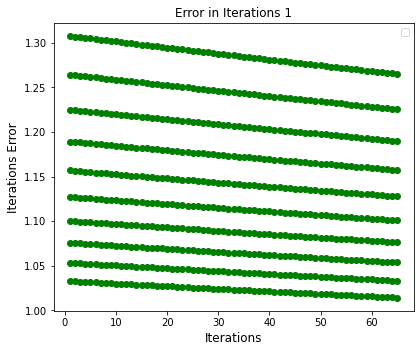

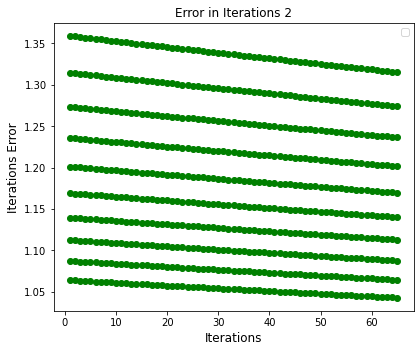

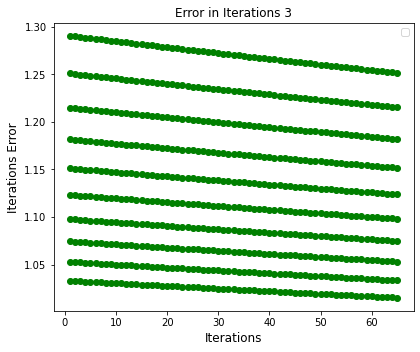

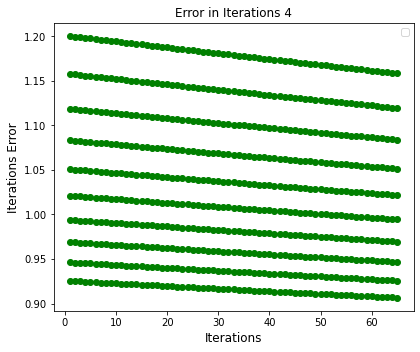

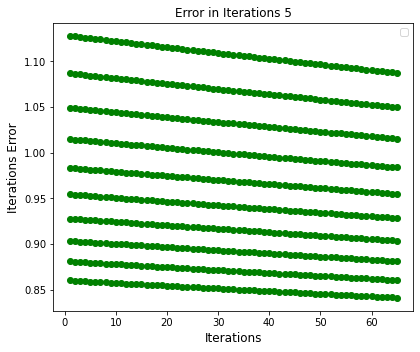

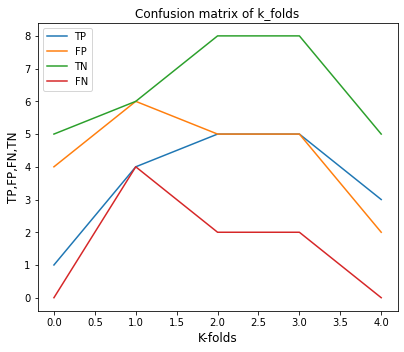

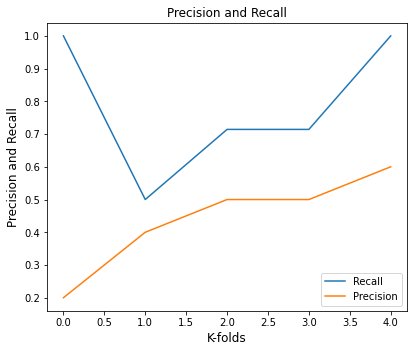

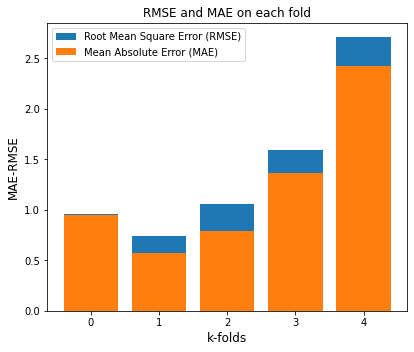

In [12]:
k_fold_training_testing(kf.n_splits)

## Hold-Out Validation

In [13]:
training_df, validation_df = train_test_split(result, test_size=.2, random_state=42)
training_df = training_df.reset_index()
validation_df = validation_df.reset_index()
print("training_df shape: ",training_df.shape)
print("validation_df shape: ",validation_df.shape)

training_df shape:  (30, 4)
validation_df shape:  (8, 4)


TestData
users_list: u 11
 layouts_visited_list: 0    GLHS2
4       L4
5       L3
7       L2
Name: layout_id, dtype: object

TestData
users_list: u 12
 layouts_visited_list: 1    GLHS5
Name: layout_id, dtype: object

TestData
users_list: u 4
 layouts_visited_list: 2    GLHS2
6       L3
Name: layout_id, dtype: object

TestData
users_list: u 9
 layouts_visited_list: 3    GLHS2
Name: layout_id, dtype: object

   index user_id layout_id  ratings  prediction
0     33    u 11     GLHS2      1.0    2.166823
1     36    u 12     GLHS5      1.0         NaN
2      4     u 4     GLHS2      1.0    1.409700
3     13     u 9     GLHS2      1.0    1.293250
4     30    u 11        L4      4.0    2.448032
5     26    u 11        L3      3.0    2.428196
6      6     u 4        L3      1.0    1.671073
7     27    u 11        L2      5.0    2.562459


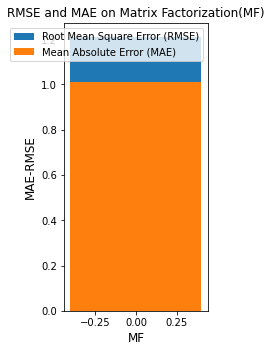

In [14]:

RMSE_funk = []
MAE_funk = []
fkrecs = FunkSVDRecs()
users_list = validation_df.user_id.unique().tolist()
validation_df_funk = {}
layouts_visited_list = []
for user in users_list:
    list_user_layouts = validation_df.loc[(validation_df.user_id == user),'layout_id']
    layouts_visited_list = list_user_layouts
    validation_df_funk = fkrecs.predict(user ,list_user_layouts,validation_df)
    print('TestData\nusers_list: {}\n layouts_visited_list: {}\n'.format(user,layouts_visited_list))
rmse = None
mae = None
print(validation_df_funk)
rmse , mae = print_validation_rmse_mae(validation_df_funk)

RMSE_funk.append(rmse)
MAE_funk.append(mae)
fig = plt.figure(figsize = (2,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title('RMSE and MAE on Matrix Factorization(MF)',fontsize=12)
ax.set_xlabel('MF',fontsize=12)
ax.set_ylabel('MAE-RMSE',fontsize=12)
#print('RMSE_funk: {}, MAE_funk: {}'.format(RMSE_funk, MAE_funk))
ax.bar(range(1), RMSE_funk,label = 'Root Mean Square Error (RMSE)')
ax.bar(range(1), MAE_funk,label='Mean Absolute Error (MAE)')
ax.legend()

In [15]:
def matrix_factorization_val_Hold_Out(validation_df,training_df):
    user_id_count = 0
    apks = []
    arks = []
    no_rec = 0
    total_precision_score = 0
    total_recall_score = 0
    svdRecommender = FunkSVDRecommender()
    TP = 0
    FP = 0
    TN = 0 
    FN = 0
    for user_id, users_test_data in validation_df.groupby('user_id'):
        user_id_count += 1
         # confirm that users' in test data must exist in the training too
        training_data_for_user = training_df.loc[(training_df['user_id'] == user_id),'layout_id'].tolist() 
        

        #dict_for_rec = training_data_for_user.to_dict(orient='records')# dictionary contains the layouts visited by current user from training set to find recommendation for him   
        dict_for_rec = training_data_for_user
        print('\ndict_for_rec: {} \n'.format(dict_for_rec))    
        relevant_ratings = list(users_test_data['layout_id']) # recommender will recommend layouts based on "dict_for_rec" recommended layouts will be compared with relevent_ratings list
        if len(dict_for_rec) > 0:
            recs = svdRecommender.recommend_items_by_ratings(user_id, dict_for_rec, num=5)# find maximum top 5 recommendation for each user in test data given the list of layouts from training data
            # if user has visited 6 out of 10 layout then recommender will recommend top 4 unvisited layout 1 needs to be optimised
            # if user has visited 2 out of 10 layouts then recommender will recommend top 5 layouts to the user
            
            if len(recs)>0:
                AP = average_precision_k(recs, relevant_ratings) # average precision@k
                AR = recall_at_k(recs, relevant_ratings) # average recall@k
                TP,FP,FN,TN = confusion_matrix_func(recs, relevant_ratings)
                arks.append(AR)
                apks.append(AP)
                total_precision_score += AP
                total_recall_score += AR
                
                print('user_id{},True_Positive: {}, False_Positive: {}, True_Negative: {}, False_Negative: {}'.format(user_id,TP,FP,TN,FN))
                ACC = (TP+TN)/(TP+FP+FN+TN)
                # Sensitivity, hit rate, recall, or true positive rate 
                TPR = TP/(TP+FN)
                # Precision or positive predictive value
                PPV = TP/(TP+FP)
                # Specificity or true negative rate
                TNR = TN/(TN+FP) 
                # Negative predictive value
                NPV = TN/(TN+FN)
                # Fall out or false positive rate
                FPR = FP/(FP+TN)
                # False negative rate
                FNR = FN/(TP+FN)
                # False discovery rate
                FDR = FP/(TP+FP)
                # F1 scroe
                F1 = 2 * (PPV * TPR)/(PPV + TPR)
                print('TPR/Recall: {}, PPV/Precision: {}, Accuracy: {}, F1: {}'.format(TPR,PPV, ACC, F1))

#                 plt_dict_confusion_analysis = {'Acuuracy':L_ACC,'Sensitivity, hit rate, recall, or true positive rate':L_TPR,'Precision or positive predictive value':L_PPV,'Specificity or true negative rate':L_TNR,
#                                               'Negative predictive value':L_NPV,'Fall out or false positive rate':L_FPR,'alse negative rate':L_FNR,'False discovery rate':L_FDR, 'F1 Score':L_F1} 
    
                
            else:
                no_rec += 1

            print(' Recommended Layouts',recs)             
            print('user: {}, user visited layouts: {}'.format(user_id,relevant_ratings)) # relevent layout is supposed as the user interaction to the layouts after getting recommendations
            #print('cold Start Users: {}'.format(cold_start_users)) # relevent layout is supposed as the user interaction to the layouts after getting recommendations
           
        print()  

    average_recall = total_recall_score/len(arks) if len(arks) > 0 else 0
    mean_average_precision = total_precision_score/len(apks) if len(apks) > 0 else 0
    output_str = " MAP@K {}, MAR@K {}, len-ap {}, len-ar {}, no_recs {}"
    print(output_str.format( mean_average_precision, average_recall, len(apks), len(arks),  no_rec),'\n')

In [16]:
print(matrix_factorization_val_Hold_Out(validation_df,training_df))


dict_for_rec: ['L5', 'GLHS4', 'GLHS1', 'GLHS3'] 

user_idu 11,True_Positive: 4, False_Positive: 1, True_Negative: 5, False_Negative: 0
TPR/Recall: 1.0, PPV/Precision: 0.8, Accuracy: 0.9, F1: 0.888888888888889
 Recommended Layouts [('L2', {'prediction': 2.5624594971304964}), ('GLHS5', {'prediction': 2.458916234783971}), ('L4', {'prediction': 2.448031643459436}), ('L3', {'prediction': 2.428195639149353}), ('GLHS2', {'prediction': 2.16682285547618})]
user: u 11, user visited layouts: ['GLHS2', 'L4', 'L3', 'L2']


dict_for_rec: ['L2', 'L3', 'L4'] 

 Recommended Layouts []
user: u 12, user visited layouts: ['GLHS5']


dict_for_rec: ['GLHS1', 'L1'] 

user_idu 4,True_Positive: 1, False_Positive: 4, True_Negative: 4, False_Negative: 1
TPR/Recall: 0.5, PPV/Precision: 0.2, Accuracy: 0.5, F1: 0.28571428571428575
 Recommended Layouts [('L2', {'prediction': 1.8053364347189398}), ('GLHS5', {'prediction': 1.7017931804626447}), ('L4', {'prediction': 1.6909085898746292}), ('L3', {'prediction': 1.67107

In [17]:
# making recommendations for individual user
class FunkSVDRecsIndividualUser:
    
    def __init__(self):
        self.user_bias = None
        self.item_bias = None
        self.avg = None
        self.modelpath = 'Models/matrixfactorization'
        self.user_factors = None
        self.item_factors = None
        self.ordered_item_bias = None
        self.model_loaded = None
        self.model_loaded = False
        self.load_model()

    def load_model(self):
        get_path = self.modelpath + '\\'
        with open(get_path+'user_bias.data', 'rb') as ub_file:
            self.user_bias = pickle.load(ub_file)
        with open(get_path+'item_bias.data', 'rb') as ub_file:
            self.item_bias = pickle.load(ub_file)
        with open(get_path+'avg.npy', 'rb') as f:
            self.avg = np.load(f)
       
        with open(get_path+'user_factors.json', 'r') as infile:
            self.user_factors = pd.DataFrame(json.load(infile)).T
        with open(get_path+'item_factors.json', 'r') as infile:
            self.item_factors = pd.DataFrame(json.load(infile)).T
        self.ordered_item_bias = list(collections.OrderedDict(sorted(self.item_bias.items())).values())
        self.model_loaded = True

    def recommend_items_by_ratings(self, user_id, active_user_items, num):
        print("user_id: {}\nuser past visited layouts:\n {}".format(user_id,active_user_items))
        rated_layouts = set(active_user_items)
        recs = {}
        if str(user_id) in self.user_factors.columns:
            user = self.user_factors[str(user_id)]
            
            items = self.item_factors
            scores = items.T.dot(user)
            sorted_scores = scores.sort_values(ascending=False)
            result = sorted_scores[:num + len(rated_layouts)]
            user_bias = 0

            if user_id in self.user_bias.keys():
                user_bias = self.user_bias[user_id]
            elif int(user_id) in self.user_bias.keys():
                user_bias = self.user_bias[int(user_id)]
                print(f'it was an int {user_bias}')

            rating = float(user_bias + self.avg)
            result += rating

            recs = {r[0]: {'prediction': r[1] + float(self.item_bias[r[0]])}
                    for r in zip(result.index, result) if r[0] not in rated_layouts}
        sorted_items = sorted(recs.items(), key=lambda item: -float(item[1]['prediction']))[:num]
        print('recommended_layouts: \n{}'.format(sorted_items))
        print()
        return sorted_items

fkrecs = FunkSVDRecsIndividualUser()
fkrecs.load_model()
users_list = validation_df.user_id.unique().tolist()
for user in users_list:
    #print("user_id{}, validation set{}_____: ".format(user_id,validation_df.loc[(validation_df.user_id == user),'layout_id']))
    list_user_layouts = training_df.loc[(training_df.user_id == user),'layout_id']
    list_user_layouts
    recs = fkrecs.recommend_items_by_ratings(user ,list_user_layouts,5)

user_id: u 11
user past visited layouts:
 8        L5
17    GLHS4
22    GLHS1
29    GLHS3
Name: layout_id, dtype: object
recommended_layouts: 
[('L2', {'prediction': 2.5624594971304964}), ('GLHS5', {'prediction': 2.458916234783971}), ('L4', {'prediction': 2.448031643459436}), ('L3', {'prediction': 2.428195639149353}), ('GLHS2', {'prediction': 2.16682285547618})]

user_id: u 12
user past visited layouts:
 14    L2
18    L3
20    L4
Name: layout_id, dtype: object
recommended_layouts: 
[]

user_id: u 4
user past visited layouts:
 11    GLHS1
19       L1
Name: layout_id, dtype: object
recommended_layouts: 
[('L2', {'prediction': 1.8053364347189398}), ('GLHS5', {'prediction': 1.7017931804626447}), ('L4', {'prediction': 1.6909085898746292}), ('L3', {'prediction': 1.6710725868281897}), ('L5', {'prediction': 1.6099655965638495})]

user_id: u 9
user past visited layouts:
 1        L4
2        L5
4     GLHS3
5     GLHS1
25    GLHS5
28       L2
Name: layout_id, dtype: object
recommended_layouts: 